# DTS boards and status
Script to set DTS to default mode and read DTS information RCU / UniBoard2

In [386]:
#
# Imports
#
import time
import numpy as np
import pylab as pl
from opcua import Client
from opcua import ua
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [387]:
RCUs = 4
NODEs = 1

In [388]:
rcu=DeviceProxy("LTS/RECV/1")
apsct=DeviceProxy("stat/APSCT/1")
apspu=DeviceProxy("stat/APSPU/1")
sst=DeviceProxy("stat/SST/1")
sdp=DeviceProxy("stat/SDP/1")
unb2c=DeviceProxy("stat/UNB2/1")
#
# Start Devices (interface to HW / FW / SW)
#
def force_start(device):
    if device.state() == DevState.FAULT:
        device.Off()
    if device.state() == DevState.OFF:
        device.initialise()
    if device.state() == DevState.INIT:
        device.Standby()
    if device.state() == DevState.STANDBY:
        device.On()
        
    return device.state()

for d in devices:
    print("Device %s is now in state %s" % (d, force_start(d)))

Device APSCT(stat/apsct/1) is now in state ON
Device APSPU(stat/apspu/1) is now in state ON
Device RECV(stat/recv/1) is now in state ON
Device SDP(stat/sdp/1) is now in state ON
Device SST(stat/sst/1) is now in state ON
Device XST(stat/xst/1) is now in state ON
Device UNB2(stat/unb2/1) is now in state ON
Device Boot(stat/boot/1) is now in state ON
Device Docker(stat/docker/1) is now in state ON


In [377]:
#
# Set DTS in default modes
#
if 1:
#    apsct.set_defaults()
    recv.set_defaults()
    recv.RCU_mask_RW = [True]*32
    recv.ANT_mask_RW = [[True]*3]*32
    recv.RCU_PWR_ANT_on_RW = [[True]*3]*32
    recv.RCU_on()
    recv.RCU_DTH_off()
    recv.RCU_band_select_RW = [[0]*3]*32
    recv.RECVTR_monitor_rate_RW = 10
    sdp.set_defaults()
    sst.set_defaults() 
sdp.TR_fpga_mask_RW = [True]*16
sst.FPGA_sst_offload_hdr_udp_destination_port_RW = [5001]*16
sst.FPGA_sst_offload_hdr_eth_destination_mac_RW = ["0c:c4:7a:c0:30:f1"]*16
sst.FPGA_sst_offload_hdr_ip_destination_address_RW = ["10.99.250.250"]*16 
sst.FPGA_sst_offload_weighted_subbands_RW = [True]*16
sdp.FPGA_processing_enable_RW = [True]*16
sst.FPGA_sst_offload_enable_RW = [True]*16


In [378]:
#
# Read and print DTS HW information
#
print("|---------+---------+------+---------------|")
print("|   BRD   |   ID    | PCB  | PCB Version   |")
print("|---------+---------+------+---------------|")
stri = "| APSCT   | {:>7d} | {:>4s} | {:>13} |".format(apsct.APSCT_PCB_ID_R, apsct.APSCT_PCB_number_R, apsct.APSCT_PCB_version_R)
print(stri)
stri = "| APSPU   | {:>7d} | {:>4s} | {:>13} |".format(apspu.APSPU_PCB_ID_R, apspu.APSPU_PCB_number_R, apspu.APSPU_PCB_version_R)
print(stri)
for unb2_cnt in range(2):
    stri = "| UNB2_{:0>2d} | {:>7d} | {:>4s} | {:>13} |".format(unb2_cnt, unb2.UNB2_PCB_ID_R[unb2_cnt], unb2.UNB2_PCB_number_R[unb2_cnt], unb2.UNB2_PCB_version_R[unb2_cnt])
    print(stri)
for rcu_cnt in range(RCUs):
    stri = "| RCU_{:0>3d} | {:>7d} | {:>4s} | {:>13} |".format(rcu_cnt, recv.RCU_PCB_ID_R[rcu_cnt], recv.RCU_PCB_number_R[rcu_cnt], recv.RCU_PCB_version_R[rcu_cnt])
    print(stri)
print("|---------+---------+------+---------------|")


|---------+---------+------+---------------|
|   BRD   |   ID    | PCB  | PCB Version   |
|---------+---------+------+---------------|
| APSCT   | 7501424 |      |             4 |
| APSPU   | 8226517 |  467 |     4PSPU-1.0 |
| UNB2_00 | 5947666 |      |             R |
| UNB2_01 |       0 |      |               |
| RCU_000 | 8393812 |  47x |  RCU2L-QM-1.0 |
| RCU_001 | 8464776 |      |               |
| RCU_002 | 8374523 |  47x |  RCU2L-QM-1.0 |
| RCU_003 | 8380426 |  47x |  RCU2L-QM-1.0 |
|---------+---------+------+---------------|


In [411]:
#
# Read APSCT information
#
if apsct.APSCT_PLL_200MHz_locked_R:
    clock = " 200MHz"
elif apsct.APSCT_PLL_160MHz_locked_R:
    clock = " 160MHz"
elif apsct.APSCT_INPUT_10MHz_good_R:
    clock = "no lock"
else:
    clock = "no ref."

stri = "APSCT Monitor Information"
print("="*len(stri))
print(stri)
print("="*len(stri))    
print("|--------+---------+-------+---------+-------+-------+-------+-------|")
print("|   PWR  |  Temp   | PPS_in|  Freq.  | Input | DIST 1| DIST2 | DIST3 |")
print("|--------+---------+-------+---------+-------+-------+-------+-------|")
stri = "| {:>5s}  | {:>5.2f}°C | {}  | {} | {:>4.2f}V | {:>4.2f}V | {:>4.2f}V | {:>4.2f}V |".format(str(apsct.APSCT_PWR_on_R), apsct.APSCT_TEMP_R, apsct.APSCT_INPUT_PPS_good_R, clock, apsct.APSCT_PWR_INPUT_3V3_R, apsct.APSCT_PWR_CLKDIST1_3V3_R, apsct.APSCT_PWR_CLKDIST2_3V3_R, apsct.APSCT_PWR_PPSDIST_3V3_R)
print(stri)
print("|--------+---------+-------+---------+-------+-------+-------+-------|")


APSCT Monitor Information
|--------+---------+-------+---------+-------+-------+-------+-------|
|   PWR  |  Temp   | PPS_in|  Freq.  | Input | DIST 1| DIST2 | DIST3 |
|--------+---------+-------+---------+-------+-------+-------+-------|
|  True  | 24.89°C | True  |  200MHz | 3.29V | 0.01V | 0.01V | 0.01V |
|--------+---------+-------+---------+-------+-------+-------+-------|


In [410]:
stri = "APS Fan speeds RMP"
print("="*len(stri))
print(stri)
print("="*len(stri))
print("|---------+---------+---------|")
print("|  FAN 1  |  FAN 2  |  FAN 3  |")
print("|---------+---------+---------|")
stri = "| {:6.2f} | {:6.2f} | {:6.2f} |".format(apspu.APSPU_FAN1_RPM_R, apspu.APSPU_FAN2_RPM_R, apspu.APSPU_FAN3_RPM_R)
print(stri)
print("|---------+---------+---------|")
stri = "APSPU power supplies"
print("="*len(stri))
print(stri)
print("="*len(stri))
print("|---------+---------+---------|")
print("|   LBA   |  RCU A  |  RCU D  |")
print("|---------+---------+---------|")
stri = "|  {:4.2f} V |  {:4.2f} V |  {:4.2f} V |".format(apspu.APSPU_LBA_VOUT_R, apspu.APSPU_RCU2A_VOUT_R, apspu.APSPU_RCU2D_VOUT_R)
print(stri)
stri = "|  {:4.2f} A |  {:4.2f} A |  {:4.2f} A |".format(apspu.APSPU_LBA_IOUT_R, apspu.APSPU_RCU2A_IOUT_R, apspu.APSPU_RCU2D_IOUT_R)
print(stri)
stri = "| {:5.2f}°C | {:5.2f}°C | {:5.2f}°C |".format(apspu.APSPU_LBA_TEMP_R, apspu.APSPU_RCU2A_TEMP_R, apspu.APSPU_RCU2D_TEMP_R)
print(stri)
print("|---------+---------+---------|")


APS Fan speeds RMP
|---------+---------+---------|
|  FAN 1  |  FAN 2  |  FAN 3  |
|---------+---------+---------|
| 1920.93 | 1920.93 | 1920.93 |
|---------+---------+---------|
APSPU power supplies
|---------+---------+---------|
|   LBA   |  RCU A  |  RCU D  |
|---------+---------+---------|
|  7.97 V |  5.60 V |  3.29 V |
|  0.38 A |  6.62 A |  4.25 A |
| 30.75°C | 32.25°C | 28.25°C |
|---------+---------+---------|


In [389]:
#
# Read RCU information
#
print("|--------+-------+---------+-------+-------+-------|")
print("|  RCU   |  PWR  | Temp    | 1V8   | 2V5   | 3V3   |")
print("|--------+-------+---------+-------+-------+-------|")
for rcu_cnt in range(RCUs):
    stri = "| RCU_{:0>2d} | {:>5s} | {:>5.2f}°C | {:>4.2f}V | {:>4.2f}V | {:>4.2f}V |".format(rcu_cnt, str(recv.RCU_PWR_good_R[rcu_cnt]), recv.RCU_TEMP_R[rcu_cnt], recv.RCU_PWR_1V8_R[rcu_cnt], recv.RCU_PWR_2V5_R[rcu_cnt], recv.RCU_PWR_3V3_R[rcu_cnt])
    print(stri)
print("|--------+-------+---------+-------+-------+-------|\n")

print("|-------+-------+---------+--------+---------+----------+----------|")
print("|  SI   | Lock  |  Atten  | Dither | Ant PWR | Ant Iout | Ant Vout |")
print("|-------+-------+---------+--------+---------+----------+----------|")
for rcu_cnt in range(RCUs):
    for si_int in range(3):
#        stri = "| SI_{:0>3d} | {:>5s} | {:>5.2f}dB | {:>5s} | |".format((rcu_cnt*3) + si_int, str(rcu.RCU_ADC_locked_R[rcu_cnt][si_int]), rcu.RCU_attenuator_dB_R[rcu_cnt][si_int], str(rcu.RCU_DTH_on_R[rcu_cnt][si_int]))
        stri = "| SI_{:0>2d} | {:>5s} | {:>5.2f}dB |  {:>5s} |   {:>5s} |  {:>5.2f} A |  {:>5.2f} V |".format((rcu_cnt*3) + si_int, str(recv.RCU_ADC_locked_R[rcu_cnt][si_int]), recv.RCU_attenuator_dB_R[rcu_cnt][si_int], str(recv.RCU_DTH_on_R[rcu_cnt][si_int]), str(recv.RCU_PWR_ANT_on_R[rcu_cnt][si_int]), recv.RCU_PWR_ANT_IOUT_R[rcu_cnt][si_int], recv.RCU_PWR_ANT_VOUT_R[rcu_cnt][si_int])
        print(stri)
print("|-------+-------+---------+--------+---------+----------+----------|\n")



|--------+-------+---------+-------+-------+-------|
|  RCU   |  PWR  | Temp    | 1V8   | 2V5   | 3V3   |
|--------+-------+---------+-------+-------+-------|
| RCU_00 |  True | 28.36°C | 1.78V | 2.55V | 3.34V |
| RCU_01 |  True | 28.60°C | 1.79V | 2.53V | 3.34V |
| RCU_02 |  True | 29.34°C | 1.79V | 2.55V | 3.32V |
| RCU_03 |  True | 29.34°C | 1.79V | 2.55V | 3.32V |
|--------+-------+---------+-------+-------+-------|

|-------+-------+---------+--------+---------+----------+----------|
|  SI   | Lock  |  Atten  | Dither | Ant PWR | Ant Iout | Ant Vout |
|-------+-------+---------+--------+---------+----------+----------|
| SI_00 |  True | 10.00dB |  False |    True |   0.02 A |   7.99 V |
| SI_01 |  True | 10.00dB |  False |    True |   0.02 A |   7.93 V |
| SI_02 |  True | 10.00dB |  False |    True |   0.02 A |   7.94 V |
| SI_03 |  True | 10.00dB |  False |    True |   0.02 A |   7.96 V |
| SI_04 |  True | 10.00dB |  False |    True |   0.02 A |   7.95 V |
| SI_05 |  True | 10.00

In [390]:
#
# Print FPGA input statistics
#
print("FPGA input statistics")
print("|-------+------+---------+------------+--------------+-------------+---------+--------+---------|")
print("|  SI   | Node | Node si |  DC-offset |    RMS       | Lock to ADC |  Err0   |  Err1  | Counter |")
print("|-------+------+---------+------------+--------------+-------------+---------+--------+---------|")
for node_cnt in range(NODEs):
    for si_int in range(12):
        stri = "| SI_{:0>2d} |  {:0>2d}  |    {:0>2d}   |{:>7.2f} LSB |  {:>7.2f} LSB |      {}      | 0x{:0>4x}  | 0x{:0>4x} |  0x{:0>4x} |".format((node_cnt*12) + si_int, node_cnt, si_int, sdp.FPGA_signal_input_mean_R[node_cnt][si_int], sdp.FPGA_signal_input_rms_R[node_cnt][si_int], sdp.FPGA_jesd204b_csr_dev_syncn_R[node_cnt][si_int], sdp.FPGA_jesd204b_rx_err0_R[node_cnt][si_int], sdp.FPGA_jesd204b_rx_err1_R[node_cnt][si_int], sdp.FPGA_jesd204b_csr_rbd_count_R[node_cnt][si_int])
        print(stri)
print("|-------+------+---------+------------+--------------+-------------+---------+--------+---------|")


FPGA input statistics
|-------+------+---------+------------+--------------+-------------+---------+--------+---------|
|  SI   | Node | Node si |  DC-offset |    RMS       | Lock to ADC |  Err0   |  Err1  | Counter |
|-------+------+---------+------------+--------------+-------------+---------+--------+---------|
| SI_00 |  00  |    00   |   0.00 LSB |     0.00 LSB |      0      | 0x00e0  | 0x0000 |  0x0000 |
| SI_01 |  00  |    01   |   0.00 LSB |     0.00 LSB |      0      | 0x00e0  | 0x0000 |  0x0000 |
| SI_02 |  00  |    02   |   0.00 LSB |     0.00 LSB |      0      | 0x00e0  | 0x0000 |  0x0000 |
| SI_03 |  00  |    03   |   0.00 LSB |     0.00 LSB |      0      | 0x00e0  | 0x0000 |  0x0000 |
| SI_04 |  00  |    04   |   0.00 LSB |     0.00 LSB |      0      | 0x0060  | 0x0000 |  0x0000 |
| SI_05 |  00  |    05   |   0.00 LSB |     0.00 LSB |      0      | 0x00e0  | 0x0038 |  0x0000 |
| SI_06 |  00  |    06   |   3.54 LSB |  4167.97 LSB |      1      | 0x0000  | 0x0000 |  0x0003 

# Legend

SI = signal input on the RCU.<br>
Node        = FPGA in the system. Node 0 is the first (top) FPGA on UniBoard2[0] left UniBoard2. <br>
Node si     = FPGA signal input.<br>
DC-offset   = Calculated mean value of the data input. <br>
RMS         = RMS value of the input stream. <br>
Lock to ADC = 1 when the JESD204 IP in the FPGA is locked to the data stream of the ADC.<br>
Err0        = Error in data transport between ADC and FPGA. For now, reset FPGA clearing <br>
Err1        = Error in data transport between ADC and FPGA. (bit 8 single corrected bit error during, bit 9 faital bit errors)<br>
Counter     = Just looks nice, normally 2 or 3 does not have to be the same.

Requested secure channel timeout to be 3600000ms, got 600000ms instead


Connected to 10.99.0.252:4840


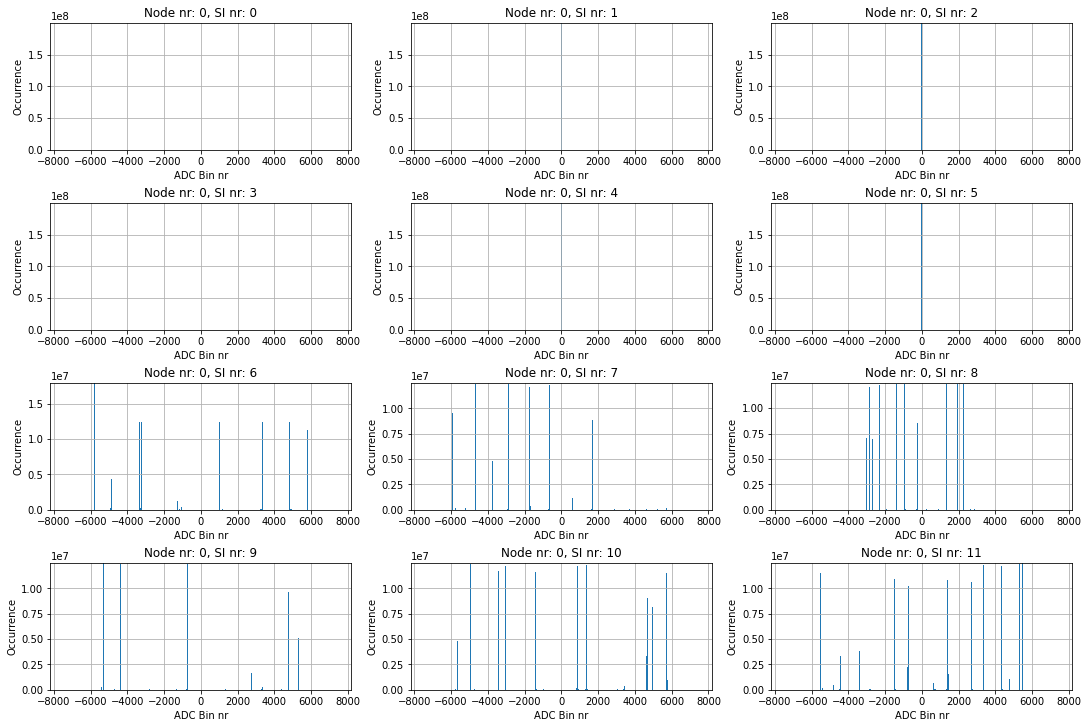


disconnect from server


In [383]:
#
# Plot Histogram (by pass Tango)
#
N_HISTO = 512
S_PN = 12
N_BITS = 14
N_LEVEL_PER_BIN = 32
host = "10.99.0.252"
port = "4840"

client = Client("opc.tcp://{}:{}/".format(host, port))

def plot_hist(Object, node=0):
        var = Object.get_child("2:FPGA_signal_input_histogram_R")
        data = var.get_value()
        np_data = np.array(data)
        bin_range = np.array(range(-256, 256))
        bin_range = bin_range*N_LEVEL_PER_BIN
        fig, axs = plt.subplots(4, 3, figsize=(15, 10), constrained_layout=True)
        ax = axs.flat
        for si_cnt in range(S_PN):
            s1 = (node * S_PN * N_HISTO) + (si_cnt * N_HISTO)
            s2 = s1 + N_HISTO
            _data = np_data[s1:s2]
            _lo, _hi = np.split(_data, 2)
            _data = np.concatenate((_hi, _lo))
            ax[si_cnt].bar(bin_range, height=_data, width=N_LEVEL_PER_BIN)
            ax[si_cnt].set_xlim([-2**(N_BITS-1), (2**(N_BITS-1))-1])
            ax[si_cnt].set_ylim([0, np.max(_data)])
            ax[si_cnt].grid(True)
            title_stri = "Node nr: {}, SI nr: {}".format(node, si_cnt)
            ax[si_cnt].set_title(title_stri)
            ax[si_cnt].set_xlabel("ADC Bin nr")
            ax[si_cnt].set_ylabel("Occurrence")
        plt.show()        
    

try:
    client.connect()
    print("Connected to {}:{}".format(host, port))
    Object = client.get_objects_node()
    plot_hist(Object, node=0)
except:
    print("Connection failed, not connected")
finally:
    print("\ndisconnect from server")
    client.disconnect()


Requested secure channel timeout to be 3600000ms, got 600000ms instead


Connected to 10.99.0.252:4840


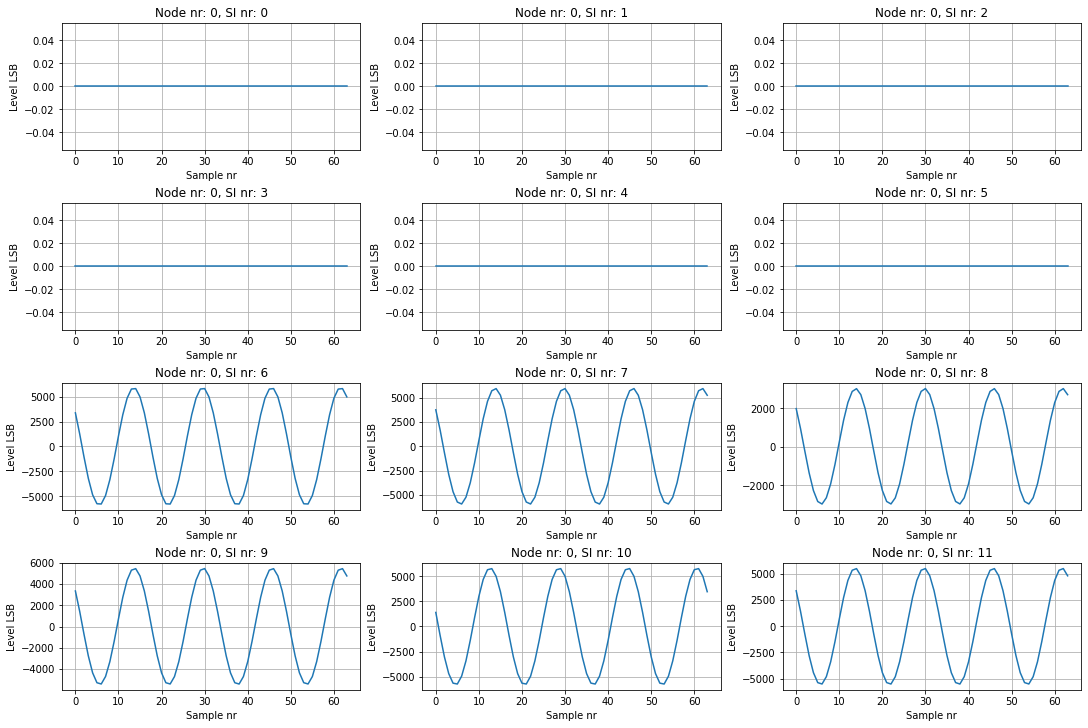


disconnect from server


In [384]:
#
# Plot Sample data (by pass Tango)
#

N_DB = 1024
S_PN = 12
N_BITS = 14
host = "10.99.0.252"
port = "4840"

client = Client("opc.tcp://{}:{}/".format(host, port))

def plot_time(Object, node=0):
        var = Object.get_child("2:FPGA_signal_input_data_buffer_R")
        data = var.get_value()
        np_data = np.array(data)
        fig, axs = plt.subplots(4, 3, figsize=(15, 10), constrained_layout=True)
        ax = axs.flat
        for si_cnt in range(S_PN):
            s1 = (node * S_PN * N_DB) + (si_cnt * N_DB)
            s2 = s1 + N_DB
            _data = np_data[s1:s2]
            ax[si_cnt].plot(_data[0:64])
            ax[si_cnt].grid(True)
            title_stri = "Node nr: {}, SI nr: {}".format(node, si_cnt)
            ax[si_cnt].set_title(title_stri)
            ax[si_cnt].set_xlabel("Sample nr")
            ax[si_cnt].set_ylabel("Level LSB")
        plt.show()        
    

try:
    client.connect()
    print("Connected to {}:{}".format(host, port))
    Object = client.get_objects_node()
    plot_time(Object, node=0)
except:
    print("Connection failed, not connected")
finally:
    print("\ndisconnect from server")
    client.disconnect()


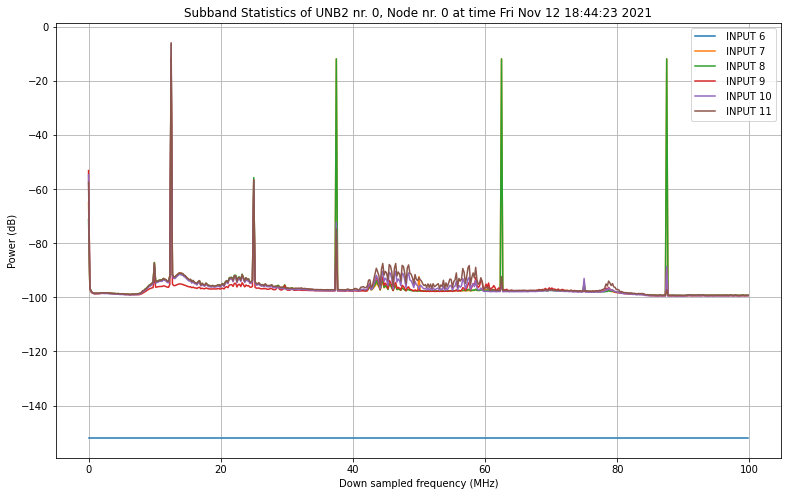

In [385]:
#
# Plot SST
#
nof_node_unb2c = 4
nof_si_node = 12
unb2_brd = 0
unb2_node = 0 
si_start=6
si_stop=12
f_as = [s/512*100 for s in range(sst.sst_r.shape[1])]
#
# Check SST stream
#
if 0:
    print("FPGA_sst_offload_enable_R: ", sst.FPGA_sst_offload_enable_R)
    print("FPGA_sst_offload_hdr_eth_destination_mac_R: ", sst.FPGA_sst_offload_hdr_eth_destination_mac_R)
    print("FPGA_sst_offload_hdr_ip_destination_address_R: ", sst.FPGA_sst_offload_hdr_ip_destination_address_R)
    print("FPGA_sst_offload_hdr_udp_destination_port_R: ", sst.FPGA_sst_offload_hdr_udp_destination_port_R)
    print("FPGA_sst_offload_weighted_subbands_R: ", sst.FPGA_sst_offload_weighted_subbands_R)
    print("nof_packets_received_R: ", sst.nof_packets_received_R)
    print("nof_valid_payloads_R: ", sst.nof_valid_payloads_R)
    print("nof_payload_errors_R: ", sst.nof_payload_errors_R)
    print("sst_timestamp_R: ", sst.sst_timestamp_R[0:5], "...")
    print("FPGA_bsn_monitor_input_nof_packets_R :", sdp.FPGA_bsn_monitor_input_nof_packets_R)
    print("FPGA_processing_enable_R: ", sdp.FPGA_processing_enable_R)
#
# Read and plot data
#
pl.figure(1, figsize=(13,8))
stri_title = "Subband Statistics of UNB2 nr. {}, Node nr. {} at time {}".format(unb2_brd, unb2_node, time.ctime(sst.last_packet_timestamp_R+2*60*60))
for ant in range((unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node+si_start,(unb2_brd*nof_node_unb2c+unb2_node)*nof_si_node+si_stop):
    dbfs = 10*np.log10(sst.sst_r[ant]+1)-128-6*4
    input_label = " INPUT " + str(ant)
    pl.plot(f_as, dbfs, label = input_label)
    power_min = 10*np.log10(np.min(sst.sst_r[ant])+1)-128-6*4
    power_middle = 10*np.log10(sst.sst_r[ant][250]+1)-128-6*4
    power_max = 10*np.log10(np.max(sst.sst_r[ant])+1)-128-6*4
pl.grid(True)
pl.ylabel('Power (dB)' )
pl.xlabel('Down sampled frequency (MHz)' )
#pl.ylim([-100, 0])
pl.legend()
pl.title(stri_title)
pl.show()

In [368]:
#
# Direct access to OPC-UA server on UniBoard2 firmare
#
from opcua import Client
from opcua import ua
host = "10.99.0.252"
port = "4840"
client = Client("opc.tcp://{}:{}/".format(host, port))
try:
    client.connect()
    print("Connected to {}:{}".format(host, port))
    Object = client.get_objects_node()
    children = Object.get_children()
    #    
# Set if statement to 1 for a list of all children of the firmware
#
    if 1:
        for i in range(len(children)):
            browse_name = children[i].get_browse_name().to_string()
            print("\t\tchild", i, ": ", browse_name)
            if browse_name in ['0:Server', '0:Aliases']:
                continue
#            print("\t\tchild", i, ": ", children[i].get_array_dimensions())
#            print("\t\tchild", i, ": ", children[i].get_data_type_as_variant_type())
#            print("\t\tchild", i, ": ", children[i].get_node_class())
    elif 0:
        enable = [True] * 16  # enable weighted subbands
        disable = [False]*16
        var = Object.get_child("2:TR_fpga_mask_RW")
        var.set_value(ua.Variant(value=list(enable), varianttype=ua.VariantType.Boolean))
        var = Object.get_child("2:FPGA_sst_offload_weighted_subbands_RW")
        var.set_value(ua.Variant(value=list(enable), varianttype=ua.VariantType.Boolean))
        var = Object.get_child("2:FPGA_processing_enable_RW")
        var.set_value(ua.Variant(value=list(enable), varianttype=ua.VariantType.Boolean))
    else:
        var = Object.get_child("2:FPGA_sst_offload_weighted_subbands_R")
        a = var.get_value()
        print(a)
        var = Object.get_child("2:FPGA_pps_capture_cnt_R")
        a = var.get_value()
        print(a)
        var = Object.get_child("2:FPGA_jesd204b_csr_dev_syncn_R")
        a = var.get_value()
        print(a)
except:
    print("Connection failed, not connected")
finally:
    print("\ndisconnect from server")
    client.disconnect()


Requested secure channel timeout to be 3600000ms, got 600000ms instead


Connected to 10.99.0.252:4840
		child 0 :  2:FPGA_beamlet_output_scale_R
		child 1 :  2:FPGA_hardware_version_R
		child 2 :  2:TR_start_time_R
		child 3 :  2:FPGA_xst_input_bsn_at_sync_R
		child 4 :  2:FPGA_xst_offload_hdr_ip_destination_address_R
		child 5 :  2:FPGA_sst_offload_hdr_udp_destination_port_RW
		child 6 :  2:FPGA_pps_expected_cnt_RW
		child 7 :  2:FPGA_sdp_info_station_id_R
		child 8 :  2:FPGA_beamlet_output_scale_RW
		child 9 :  2:FPGA_sdp_info_observation_id_R
		child 10 :  2:FPGA_signal_input_samples_delay_RW
		child 11 :  2:FPGA_wg_enable_R
		child 12 :  2:TR_tod_R
		child 13 :  2:FPGA_signal_input_samples_delay_R
		child 14 :  2:FPGA_wg_amplitude_R
		child 15 :  2:TR_tod_ptp_status_R
		child 16 :  2:FPGA_bsn_monitor_input_nof_valid_R
		child 17 :  2:FPGA_xst_subband_select_RW
		child 18 :  2:FPGA_xst_integration_interval_RW
		child 19 :  2:FPGA_bst_offload_hdr_ip_destination_address_R
		child 20 :  2:FPGA_xst_offload_hdr_udp_destination_port_R
		child 21 :  2:FPGA_pro

In [392]:

attr_names = apspu.get_attribute_list()
for i in attr_names:
    print(i)

version_R
opcua_missing_attributes_R
APSPUTR_I2C_error_R
APSPUTR_monitor_rate_RW
APSPUTR_translator_busy_R
APSPU_FAN1_RPM_R
APSPU_FAN2_RPM_R
APSPU_FAN3_RPM_R
APSPU_LBA_IOUT_R
APSPU_LBA_TEMP_R
APSPU_LBA_VOUT_R
APSPU_PCB_ID_R
APSPU_PCB_number_R
APSPU_PCB_version_R
APSPU_RCU2A_IOUT_R
APSPU_RCU2A_TEMP_R
APSPU_RCU2A_VOUT_R
APSPU_RCU2D_IOUT_R
APSPU_RCU2D_TEMP_R
APSPU_RCU2D_VOUT_R
State
Status
